In [1]:
!pip install keras

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from sklearn.metrics import confusion_matrix,  classification_report
from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical

In [3]:
data = pd.read_csv('ds1.csv',sep=';')

In [4]:
data

,ID,Min_EKG,Max_EKG,Mean_EKG,STDEV_EKG,Min_GSR,Max_GSR,Mean_GSR,STDEV_GSR,Min_Tep,Max_Tep,Mean_Tep,STDEV_Tep,Label
0,3_h,10,617,333.516508,48.163003,317,337,330.212305,4.077739,37.15,38.61,37.894830,2.972412e-01,Neutral
1,5_h,10,655,333.662258,74.671788,273,315,302.143985,9.844223,35.68,36.66,36.170000,4.264903e-02,Negative
2,6_h,172,653,326.923148,33.356241,366,388,381.556474,4.600456,36.17,36.66,36.630415,1.169313e-01,Negative
3,7_h,204,519,332.974105,28.862731,273,322,305.297337,10.751020,37.15,37.63,37.256868,2.000672e-01,Neutral
4,8_h,225,562,356.487284,25.060835,376,418,397.679890,10.684603,37.63,38.12,37.722453,1.920770e-01,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,13_z,271,472,333.539683,22.439852,341,371,358.503409,9.699814,35.68,36.17,36.135412,1.262514e-01,Negative
73,17_z,276,501,333.692240,24.240372,227,330,291.081818,27.876547,35.68,35.68,35.680000,4.288558e-14,Negative
74,18_z,9,654,334.505291,47.567666,156,204,186.990909,7.814356,36.17,36.66,36.648471,7.471383e-02,Negative
75,19_z,296,392,332.582598,10.325506,333,341,336.893182,1.676497,37.63,38.61,37.872118,3.082713e-01,Negative


# **Kontrola dát**


In [5]:
data['Label'].value_counts()

Negative    37
Neutral     25
Positive    15
Name: Label, dtype: int64

In [6]:
mapovanie = {'Negative': 0, 'Positive': 1, 'Neutral': 2}

In [7]:
def preprocesing(df):
    df = df.copy()
    
    df['Label'] = df['Label'].replace(mapovanie)
    
    y = df['Label'].copy()
    X = df.drop(['ID','Label'], axis=1).copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=12)
    
    return X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = preprocesing(data)
#X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [9]:
#X_train = X_train.apply(lambda row: row.fillna(row.mean()), axis=1)


In [10]:
#X_test = X_test.apply(lambda row: row.fillna(row.mean()), axis=1)

In [11]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)


scaler = StandardScaler().fit(X_test)
X_test_scaled = scaler.transform(X_test)


In [12]:
from keras.layers.core.dropout import Dropout
from keras.layers import LeakyReLU
from tensorflow.keras import regularizers

model = Sequential()
model.add(Dense(64, input_dim=12,kernel_regularizer=regularizers.l2(0.001)))
model.add(LeakyReLU(alpha=0.01))
#model.add(BatchNormalization())
model.add(Dropout(0.02))
model.add(Dense(32,kernel_regularizer=regularizers.l2(0.001)))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.02))
model.add(Dense(16,kernel_regularizer=regularizers.l2(0.001)))
model.add(LeakyReLU(alpha=0.01))
#model.add(BatchNormalization())
model.add(Dropout(0.07))
model.add(Dense(3, activation= 'softmax'))

sgd = SGD(learning_rate=0.1, decay=5e-4, momentum= 0.9,nesterov= True)

In [13]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                832       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32)                0         
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                5

In [14]:

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer= 'Adamax', 
              metrics=['accuracy'])

In [15]:
%%time

keras_callbacks   = [ tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', min_delta=0.0001)]
trenovanie = model.fit(X_train_scaled, y_train, batch_size=30, epochs=100, validation_split=0.17, verbose=1,callbacks= keras_callbacks )

Epoch 1/100
2/2 [==============================] - 1s 214ms/step - loss: 1.2254 - accuracy: 0.3600 - val_loss: 1.1403 - val_accuracy: 0.5455
Epoch 2/100
2/2 [==============================] - 0s 31ms/step - loss: 1.1951 - accuracy: 0.3800 - val_loss: 1.1267 - val_accuracy: 0.4545
Epoch 3/100
2/2 [==============================] - 0s 24ms/step - loss: 1.1749 - accuracy: 0.4200 - val_loss: 1.1154 - val_accuracy: 0.5455
Epoch 4/100
2/2 [==============================] - 0s 195ms/step - loss: 1.1648 - accuracy: 0.4000 - val_loss: 1.1031 - val_accuracy: 0.6364
Epoch 5/100
2/2 [==============================] - 0s 42ms/step - loss: 1.1666 - accuracy: 0.4600 - val_loss: 1.0921 - val_accuracy: 0.6364
Epoch 6/100
2/2 [==============================] - 0s 42ms/step - loss: 1.1369 - accuracy: 0.4800 - val_loss: 1.0816 - val_accuracy: 0.6364
Epoch 7/100
2/2 [==============================] - 0s 36ms/step - loss: 1.1193 - accuracy: 0.5200 - val_loss: 1.0722 - val_accuracy: 0.6364
Epoch 8/100
2/2 [=

In [16]:
model_acc = model.evaluate(X_test_scaled, y_test, verbose=0)[1]
print("Accuracy: {:.3f}%".format(model_acc * 100))

Accuracy: 62.500%


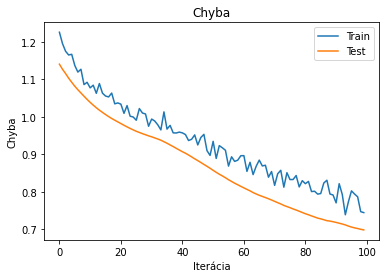

In [17]:
plt.plot(trenovanie.history['loss']) 
plt.plot(trenovanie.history['val_loss']) 
plt.ylabel('Chyba') 
plt.xlabel('Iterácia')
plt.title('Chyba') 
plt.legend(['Train', 'Test'], loc='upper right') 
plt.show()

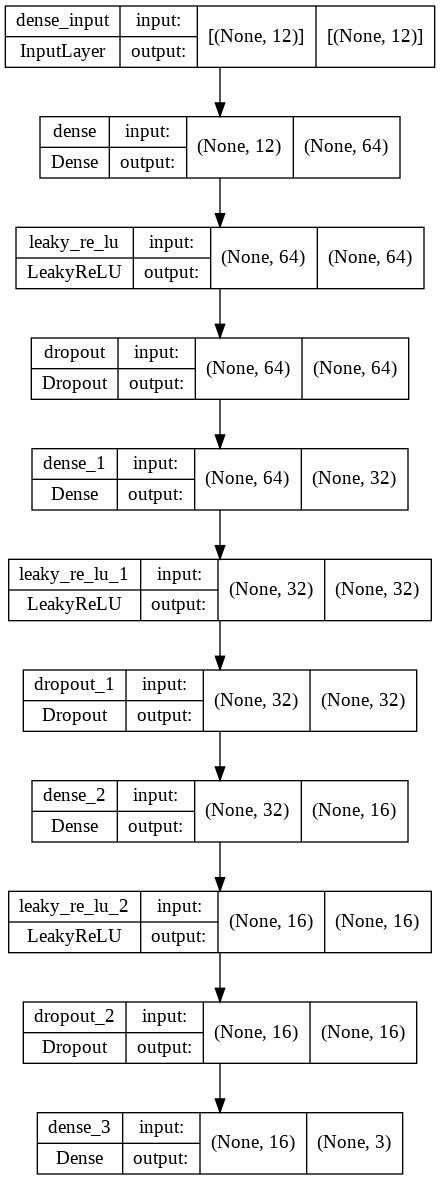

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model2.png',show_shapes=True, show_layer_names=True)